In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import time
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
import numpy as np

class EEGScaler:
    """Standardize EEG data per electrode (channel)."""
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        # X: (samples, freq, electrodes, 1)
        self.mean_ = X.mean(axis=(0, 1), keepdims=True)
        self.scale_ = X.std(axis=(0, 1), keepdims=True) + 1e-8
        return self

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        return X_scaled * self.scale_ + self.mean_

In [3]:
df = pd.read_csv("./processed_adhdata.csv")
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD->0, Control->1

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

# shape: (windows, freqs, features)
full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

X = full_ndarray[:, :, 2:]     # drop ID/Frequency columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Standardize across the entire dataset
scaler = EEGScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)

Train shape: (6623, 77, 19, 1)


In [90]:
import pickle

exported_scaler = EEGScaler()
exported_scaler.fit(X)

with open('saved_scaler.pkl', 'wb') as file:
    pickle.dump(exported_scaler, file)

In [4]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        # -> (N, 1, freq, electrodes)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=36, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=36, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class EEG_CNN_LSTM(nn.Module):
    """
    CNN -> LSTM -> FC
    Input: (N, 1, freq, electrodes)
    """
    def __init__(self, lstm_hidden=64, lstm_layers=2, dropout=0.3, num_classes=2):
        super().__init__()

        # --- CNN feature extractor ---
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(2)

        # Determine flattened feature size after CNN
        with torch.no_grad():
            dummy = torch.zeros(1, 1, X_train.shape[1], X_train.shape[2])
            out = self._forward_cnn(dummy)
            # We'll treat the *width* dimension as sequence length
            # and flatten channels*height as LSTM input_size
            self.seq_len = out.size(-1)
            self.feature_dim = out.size(1) * out.size(2)   # (channels * height)

        # --- LSTM ---
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        # --- Classifier ---
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden, num_classes)
        )

    def _forward_cnn(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        return x  # (N, C, H, W)

    def forward(self, x):
        # CNN extraction
        x = self._forward_cnn(x)           # (N, C, H, W)

        # Prepare for LSTM: treat W as sequence length
        x = x.permute(0, 3, 1, 2)          # (N, W, C, H)
        x = x.reshape(x.size(0), x.size(1), -1)  # (N, seq_len=W, feature_dim=C*H)

        # LSTM
        _, (h_n, _) = self.lstm(x)
        out = h_n[-1]                      # last layer hidden state

        # Classification
        return self.fc(out)

    def fit(self, train_loader, val_loader, epochs, criterion, optimizer,
            device="cpu", patience=30):
        best_val_loss = float('inf')
        no_improve = 0
        best_state = None

        train_losses, val_losses = [], []
        train_accs,  val_accs  = [], []

        for epoch in range(epochs):
            # ---- Train ----
            self.train()
            train_loss, train_correct = 0.0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = self(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * xb.size(0)
                train_correct += (out.argmax(1) == yb).sum().item()

            train_loss /= len(train_loader.dataset)
            train_acc  = train_correct / len(train_loader.dataset)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # ---- Validate ----
            self.eval()
            val_loss, val_correct = 0.0, 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = self(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item() * xb.size(0)
                    val_correct += (out.argmax(1) == yb).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc  = val_correct / len(val_loader.dataset)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1:03d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_loss - train_loss > 0.5:
                print("Overfitting detected")
                break

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = self.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered.")
                    break

        if best_state:
            self.load_state_dict(best_state)

        return {
            "train_losses": np.array(train_losses),
            "val_losses":   np.array(val_losses),
            "train_accs":   np.array(train_accs),
            "val_accs":     np.array(val_accs)
        }


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN_LSTM(lstm_layers=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-5, weight_decay=1e-5)

history = model.fit(train_loader, test_loader,
                    epochs=100,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device,
                    patience=30)

Epoch 001 | Train Loss: 0.6796 Acc: 0.5766 | Val Loss: 0.6724 Acc: 0.5996
Epoch 002 | Train Loss: 0.6738 Acc: 0.5866 | Val Loss: 0.6702 Acc: 0.6063
Epoch 003 | Train Loss: 0.6730 Acc: 0.5890 | Val Loss: 0.6692 Acc: 0.6081
Epoch 004 | Train Loss: 0.6686 Acc: 0.5955 | Val Loss: 0.6661 Acc: 0.5996
Epoch 005 | Train Loss: 0.6671 Acc: 0.5979 | Val Loss: 0.6621 Acc: 0.6135
Epoch 006 | Train Loss: 0.6635 Acc: 0.6041 | Val Loss: 0.6584 Acc: 0.6165
Epoch 007 | Train Loss: 0.6593 Acc: 0.6040 | Val Loss: 0.6532 Acc: 0.6220
Epoch 008 | Train Loss: 0.6545 Acc: 0.6086 | Val Loss: 0.6475 Acc: 0.6220
Epoch 009 | Train Loss: 0.6503 Acc: 0.6165 | Val Loss: 0.6433 Acc: 0.6304
Epoch 010 | Train Loss: 0.6456 Acc: 0.6239 | Val Loss: 0.6370 Acc: 0.6486
Epoch 011 | Train Loss: 0.6379 Acc: 0.6405 | Val Loss: 0.6278 Acc: 0.6667
Epoch 012 | Train Loss: 0.6335 Acc: 0.6515 | Val Loss: 0.6199 Acc: 0.6733
Epoch 013 | Train Loss: 0.6255 Acc: 0.6665 | Val Loss: 0.6163 Acc: 0.6926
Epoch 014 | Train Loss: 0.6234 Acc: 0.

In [7]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        print(xb)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))

tensor([[[[ 7.3296e-03, -7.5357e-02,  1.6056e-01,  ...,  9.6711e-03,
            2.1565e-01,  8.0934e-01],
          [-4.4770e-02,  2.9522e-02,  4.0522e-01,  ...,  5.2854e-01,
            9.2752e-01, -9.8076e-03],
          [-6.3003e-02, -6.0752e-02,  3.1746e-03,  ..., -4.8399e-02,
           -7.8526e-02,  7.3844e-02],
          ...,
          [-1.2010e-01, -9.2914e-02, -9.9177e-02,  ..., -1.1106e-01,
           -1.2571e-01, -1.1528e-01],
          [-1.2011e-01, -9.2914e-02, -9.9189e-02,  ..., -1.1107e-01,
           -1.2571e-01, -1.1528e-01],
          [-1.2011e-01, -9.2914e-02, -9.9200e-02,  ..., -1.1107e-01,
           -1.2571e-01, -1.1528e-01]]],


        [[[ 9.7656e-01,  3.1252e-01,  1.3842e+00,  ...,  1.6304e+00,
            1.1518e+00,  1.3044e-01],
          [ 7.2697e-02,  4.4303e-02,  2.1668e-02,  ...,  2.5444e-01,
            1.6741e-01,  5.6630e-01],
          [ 1.0203e-02,  4.1871e-02,  5.2431e-01,  ...,  7.2797e-01,
            4.9840e-01,  3.5385e-01],
          ...,
   

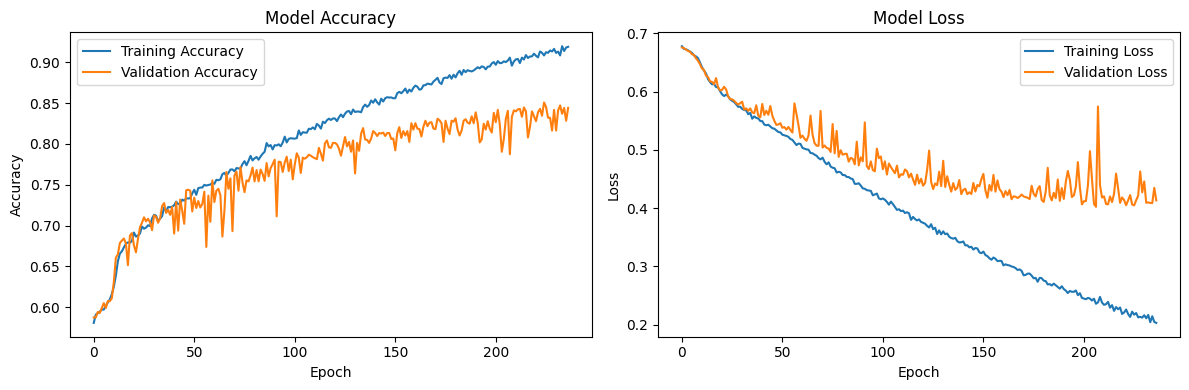

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class EEG_CNN_LSTM_HPO(nn.Module):
    def __init__(self,
                 cnn_kernels_1=32,
                 cnn_kernel_size_1=3,
                 cnn_kernels_2=64,
                 cnn_kernel_size_2=3,
                 cnn_dropout=0.3,
                 cnn_dense=64,
                 lstm_hidden_size=64,
                 lstm_layers=2,
                 lstm_dense=64,
                 dropout=0.3,
                 num_classes=2):
        super().__init__()

        # --- CNN feature extractor (configurable) ---
        pad1 = cnn_kernel_size_1 // 2
        self.conv1 = nn.Conv2d(1, int(cnn_kernels_1), kernel_size=cnn_kernel_size_1, padding=pad1)
        self.pool1 = nn.AvgPool2d(2)
        pad2 = cnn_kernel_size_2 // 2
        self.conv2 = nn.Conv2d(int(cnn_kernels_1), int(cnn_kernels_2), kernel_size=cnn_kernel_size_2, padding=pad2)
        self.pool2 = nn.AvgPool2d(2)
        self.cnn_dropout = nn.Dropout(cnn_dropout)

        # compute dims after CNN using X_train shape present in the session
        with torch.no_grad():
            dummy = torch.zeros(1, 1, X_train.shape[1], X_train.shape[2])
            out = self._forward_cnn(dummy)
            # We'll treat width (W) as seq_len and flatten channels*height as feature_dim
            self.seq_len = out.size(-1)           # W
            self.feature_dim = out.size(1) * out.size(2)  # C * H

        # projection per time-step from feature_dim -> cnn_dense
        self.cnn_dense = nn.Linear(self.feature_dim, int(cnn_dense))

        # --- LSTM (takes cnn_dense as input_size) ---
        self.lstm = nn.LSTM(
            input_size=int(cnn_dense),
            hidden_size=int(lstm_hidden_size),
            num_layers=int(lstm_layers),
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        # optional dense after LSTM
        self.lstm_dense = nn.Linear(int(lstm_hidden_size), int(lstm_dense))

        # final classifier (match your original final style: dropout + linear)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(int(lstm_dense), num_classes)
        )

    def _forward_cnn(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.cnn_dropout(x)
        return x  # (N, C, H, W)

    def forward(self, x):
        # CNN extraction
        x = self._forward_cnn(x)           # (N, C, H, W)

        # Prepare for LSTM: treat W as sequence length, flatten C*H to feature
        x = x.permute(0, 3, 1, 2)          # (N, W, C, H)
        x = x.reshape(x.size(0), x.size(1), -1)  # (N, seq_len=W, feature_dim=C*H)

        # project per time-step
        x = F.relu(self.cnn_dense(x))      # (N, seq_len, cnn_dense)

        # LSTM
        _, (h_n, _) = self.lstm(x)         # h_n: (num_layers, batch, hidden)
        out = h_n[-1]                      # last layer hidden state -> (batch, hidden)

        # post-LSTM dense + classifier
        out = F.relu(self.lstm_dense(out))
        return self.classifier(out)

    # Fit method adapted from your original
    def fit(self, train_loader, val_loader, epochs, criterion, optimizer,
            device="cpu", patience=30, is_verbose=True):
        best_val_loss = float('inf')
        no_improve = 0
        best_state = None

        train_losses, val_losses = [], []
        train_accs,  val_accs  = [], []

        for epoch in range(epochs):
            # ---- Train ----
            self.train()
            train_loss, train_correct = 0.0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = self(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * xb.size(0)
                train_correct += (out.argmax(1) == yb).sum().item()

            train_loss /= len(train_loader.dataset)
            train_acc  = train_correct / len(train_loader.dataset)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # ---- Validate ----
            self.eval()
            val_loss, val_correct = 0.0, 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = self(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item() * xb.size(0)
                    val_correct += (out.argmax(1) == yb).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc  = val_correct / len(val_loader.dataset)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if is_verbose:
                print(f"Epoch {epoch+1:03d} | "
                      f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            # Early stopping
            if val_loss <= best_val_loss:
                best_val_loss = val_loss
                best_state = self.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered.")
                    break

        if best_state:
            self.load_state_dict(best_state)

        return {
            "train_losses": np.array(train_losses),
            "val_losses":   np.array(val_losses),
            "train_accs":   np.array(train_accs),
            "val_accs":     np.array(val_accs)
        }

In [10]:
import itertools

def batched(iterable, n, *, strict=False):
    # batched('ABCDEFG', 2) → AB CD EF G
    if n < 1:
        raise ValueError('n must be at least one')
    iterator = iter(iterable)
    while batch := tuple(itertools.islice(iterator, n)):
        if strict and len(batch) != n:
            raise ValueError('batched(): incomplete batch')
        yield batch

In [11]:
def get_dataset(df, scaler: EEGScaler, is_train=False, batch_size=36):
    frequency_count = len(df['Frequency'].unique())
    window_count = len(df['Window'].unique())
    numeric_df = df.drop(['ID', 'Window'], axis=1)

    # shape: (windows, freqs, features)
    full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

    X = full_ndarray[:, :, 2:]     # drop ID/Class columns
    y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

    # Standardize across the entire dataset
    if is_train:
        scaler.fit(X)
    X = scaler.transform(X)

    # Add channel dimension (N, 1, freq, electrodes)
    X = X[..., np.newaxis]   # (N, freq, electrodes, 1)

    return DataLoader(EEGDataset(X, y),
                      batch_size=batch_size,
                      shuffle=is_train)

In [12]:
import numpy as np
import torch
import torch.nn as nn
from hyperopt import fmin, tpe, hp, STATUS_OK
import torch.optim as optim

pytorch_total_params = sum(p.numel() for p in model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Hyperopt search space
# -------------------------
space = {
    'cnn_kernels_1'    : hp.choice('cnn_kernels_1', [16, 32, 48, 64]),
    'cnn_kernel_size_1': hp.choice('cnn_kernel_size_1', [3, 5]),
    'cnn_kernels_2'    : hp.choice('cnn_kernels_2', [16, 32, 64, 96]),
    'cnn_kernel_size_2': hp.choice('cnn_kernel_size_2', [3, 5]),
    'cnn_dropout'      : hp.uniform('cnn_dropout', 0.0, 0.7),
    'cnn_dense'        : hp.choice('cnn_dense', [32, 64, 128, 256]),
    'lstm_hidden_size' : hp.choice('lstm_hidden_size', [32, 64, 96, 128]),
    'lstm_layers'      : hp.choice('lstm_layers', [1, 2, 3, 4, 5, 6]),
    'lstm_dense'       : hp.choice('lstm_dense', [32, 64, 128, 256]),
    'learning_rate'    : hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'optimizer'        : hp.choice('optimizer', ['adam', 'rmsprop', 'sgd']),
    'batch_size'       : hp.choice('batch_size', [32, 36, 48, 64, 80, 96])
}

In [13]:
import itertools

# -------------------------
# k-Fold CV for Hyperopt
# -------------------------
def objective(params):
    # map params to integers where needed
    params = dict(params)  # copy
    params['cnn_kernels_1'] = int(params['cnn_kernels_1'])
    params['cnn_kernel_size_1'] = int(params['cnn_kernel_size_1'])
    params['cnn_kernels_2'] = int(params['cnn_kernels_2'])
    params['cnn_kernel_size_2'] = int(params['cnn_kernel_size_2'])
    params['cnn_dense'] = int(params['cnn_dense'])
    params['lstm_hidden_size'] = int(params['lstm_hidden_size'])
    params['lstm_layers'] = int(params['lstm_layers'])
    params['lstm_dense'] = int(params['lstm_dense'])
    params['batch_size'] = int(params['batch_size'])

    print("Trial params:", params)

    criterion = nn.CrossEntropyLoss()
    unique_subjects = df['ID'].unique()
    losses = []
    variances = []
    batch_size = params['batch_size']

    K_FOLDS = 11
    fold_size = len(unique_subjects) // K_FOLDS

    cyclic = itertools.cycle(unique_subjects)
    batched_cyclic = batched(cyclic, n=fold_size)
    folds = itertools.islice(batched_cyclic, K_FOLDS)

    for i, fold in enumerate(folds):
        print(f"Starting fold {i + 1}/{K_FOLDS}")

        train_df = df[~df['ID'].isin(fold)]
        val_df   = df[df['ID'].isin(fold)]

        print(train_df.shape, val_df.shape)

        scaler = EEGScaler()
        train_loader = get_dataset(train_df, scaler, is_train=True, batch_size=batch_size)
        val_loader  = get_dataset(val_df, scaler, is_train=False, batch_size=batch_size)

        model = EEG_CNN_LSTM_HPO(
            cnn_kernels_1=params['cnn_kernels_1'],
            cnn_kernel_size_1=params['cnn_kernel_size_1'],
            cnn_kernels_2=params['cnn_kernels_2'],
            cnn_kernel_size_2=params['cnn_kernel_size_2'],
            cnn_dropout=float(params['cnn_dropout']),
            cnn_dense=params['cnn_dense'],
            lstm_hidden_size=params['lstm_hidden_size'],
            lstm_layers=params['lstm_layers'],
            lstm_dense=params['lstm_dense'],
            dropout=float(params['cnn_dropout']),
            num_classes=2
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = {
            'adam': optim.Adam(model.parameters(),
                               lr=params['learning_rate'],
                               weight_decay=1e-4),
            'rmsprop': optim.RMSprop(model.parameters(),
                                     lr=params['learning_rate'],
                                     weight_decay=1e-4),
            'sgd': optim.SGD(model.parameters(),
                             lr=params['learning_rate'],
                             momentum=0.9,
                             weight_decay=1e-4),
            }[params['optimizer']]

        # Train with modest epochs; early stopping inside fit handles rest
        history = model.fit(
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=60,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            patience=15,
            is_verbose=True
        )

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                preds = model(xb).argmax(1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        loss = history['val_losses']
        mean_loss = np.min(loss)
        losses.append(mean_loss)

        acc = accuracy_score(all_labels, all_preds)

        last_5_or_less = history["val_losses"]
        last_5_or_less = last_5_or_less[-min(len(last_5_or_less), 5)]
        variance = np.var(last_5_or_less)
        variances.append(variance)

        print(f"Fold {i + 1} Accuracy:", acc)

    loss = np.mean(losses)
    tail_variance = np.var(variances)
    score = loss + tail_variance

    print(f"k-Fold CV Mean Accuracy: {loss:.4f} ± {np.std(losses):.4f}")
    print(f"k-Fold CV Tail Variance: {tail_variance:.4f}")

    # Hyperopt minimizes -> return negative accuracy
    return {'loss': score, 'status': STATUS_OK, 'attachments': {'history': history}}


In [ ]:
# -------------------------
# LOSOCV for Hyperopt
# -------------------------
def objective(params):
    # map params to integers where needed
    params = dict(params)  # copy
    params['cnn_kernels_1'] = int(params['cnn_kernels_1'])
    params['cnn_kernel_size_1'] = int(params['cnn_kernel_size_1'])
    params['cnn_kernels_2'] = int(params['cnn_kernels_2'])
    params['cnn_kernel_size_2'] = int(params['cnn_kernel_size_2'])
    params['cnn_dense'] = int(params['cnn_dense'])
    params['lstm_hidden_size'] = int(params['lstm_hidden_size'])
    params['lstm_layers'] = int(params['lstm_layers'])
    params['lstm_dense'] = int(params['lstm_dense'])
    params['batch_size'] = int(params['batch_size'])

    print("Trial params:", params)

    criterion = nn.CrossEntropyLoss()
    unique_subjects = df['ID'].unique()

    losses = []
    variances = []
    batch_size = params['batch_size']

    for i, subj in enumerate(unique_subjects):
        scaler = EEGScaler()
        train_loader = get_dataset(df[df['ID'] != subj], scaler, is_train=True, batch_size=batch_size)
        val_loader  = get_dataset(df[df['ID'] == subj], scaler, is_train=False, batch_size=batch_size)

        model = EEG_CNN_LSTM_HPO(
            cnn_kernels_1=params['cnn_kernels_1'],
            cnn_kernel_size_1=params['cnn_kernel_size_1'],
            cnn_kernels_2=params['cnn_kernels_2'],
            cnn_kernel_size_2=params['cnn_kernel_size_2'],
            cnn_dropout=float(params['cnn_dropout']),
            cnn_dense=params['cnn_dense'],
            lstm_hidden_size=params['lstm_hidden_size'],
            lstm_layers=params['lstm_layers'],
            lstm_dense=params['lstm_dense'],
            dropout=float(params['cnn_dropout']),
            num_classes=2
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = {
            'adam': optim.Adam(model.parameters(),
                               lr=params['learning_rate'],
                               weight_decay=1e-4),
            'rmsprop': optim.RMSprop(model.parameters(),
                                     lr=params['learning_rate'],
                                     weight_decay=1e-4),
            'sgd': optim.SGD(model.parameters(),
                             lr=params['learning_rate'],
                             momentum=0.9,
                             weight_decay=1e-4),
            }[params['optimizer']]

        # Train with modest epochs; early stopping inside fit handles rest
        history = model.fit(
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=60,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            patience=12,
            is_verbose=True
        )

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                preds = model(xb).argmax(1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        loss = history['val_losses']
        mean_loss = np.min(loss)
        losses.append(mean_loss)

        acc = accuracy_score(all_labels, all_preds)

        last_5_or_less = history["val_losses"]
        last_5_or_less = last_5_or_less[-min(len(last_5_or_less), 5)]
        variance = np.var(last_5_or_less)
        variances.append(variance)

        print(f"Fold {i + 1} Accuracy:", acc)

    loss = np.mean(losses)
    tail_variance = np.var(variances)
    score = loss + tail_variance

    # Hyperopt minimizes -> return negative accuracy
    return {'loss': score, 'status': STATUS_OK, 'attachments': {'history': history}}


In [ ]:
# -------------------------
# Single Objective for Hyperopt
# -------------------------
def objective(params):
    # map params to integers where needed
    params = dict(params)  # copy
    params['cnn_kernels_1'] = int(params['cnn_kernels_1'])
    params['cnn_kernel_size_1'] = int(params['cnn_kernel_size_1'])
    params['cnn_kernels_2'] = int(params['cnn_kernels_2'])
    params['cnn_kernel_size_2'] = int(params['cnn_kernel_size_2'])
    params['cnn_dense'] = int(params['cnn_dense'])
    params['lstm_hidden_size'] = int(params['lstm_hidden_size'])
    params['lstm_layers'] = int(params['lstm_layers'])
    params['lstm_dense'] = int(params['lstm_dense'])
    params['batch_size'] = int(params['batch_size'])

    print("Trial params:", params)

    # build dataloaders from the existing train_ds/test_ds in this session
    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    val_loader   = DataLoader(test_ds,  batch_size=params['batch_size'], shuffle=False)

    # create model (note we pass dropout into lstm dropout and cnn dropout)
    model = EEG_CNN_LSTM_HPO(
        cnn_kernels_1=params['cnn_kernels_1'],
        cnn_kernel_size_1=params['cnn_kernel_size_1'],
        cnn_kernels_2=params['cnn_kernels_2'],
        cnn_kernel_size_2=params['cnn_kernel_size_2'],
        cnn_dropout=float(params['cnn_dropout']),
        cnn_dense=params['cnn_dense'],
        lstm_hidden_size=params['lstm_hidden_size'],
        lstm_layers=params['lstm_layers'],
        lstm_dense=params['lstm_dense'],
        dropout=float(params['cnn_dropout']), # use cnn_dropout as a simple shared dropout param
        num_classes=2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
    elif params['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
    else:
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=1e-4)

    # Train with modest epochs; early stopping inside fit handles rest
    history = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=60,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        patience=10
    )

    best_val_loss = float(np.min(history['val_losses'])) if len(history['val_losses'])>0 else 0.0

    # Hyperopt minimizes -> return negative accuracy
    return {'loss': best_val_loss, 'status': STATUS_OK, 'attachments': {'history': history}}


In [ ]:
from hyperopt import Trials
trials = Trials()

print("Starting TPE search...")
t0 = time.time()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=150,   # increase for more thorough search
    trials=trials
)

print("Best hyperparameters:", best)
t1 = time.time()
print(f"TPE search finished in {(t1 - t0):.2f} seconds")

print("Best (raw indices):", best)
# Convert choice indices back to values for readability:
def choice_value(key, val):
    mapping = {
        'cnn_kernels_1': [16, 32, 48, 64],
        'cnn_kernel_size_1': [3, 5],
        'cnn_kernels_2': [16, 32, 64, 96],
        'cnn_kernel_size_2': [3, 5],
        'cnn_dense': [32, 64, 128, 256],
        'lstm_hidden_size': [32, 64, 96, 128],
        'lstm_layers': [1, 2, 3, 4, 5, 6],
        'lstm_dense': [32, 64, 128, 256],
        'optimizer': ['adam', 'rmsprop', 'sgd'],
        'batch_size': [32, 36, 48, 64, 80, 96]
    }
    return mapping[key][int(val)] if key in mapping else val

readable = {k: choice_value(k, v) if k in ['cnn_kernels_1','cnn_kernel_size_1','cnn_kernels_2',
                                           'cnn_kernel_size_2', 'cnn_dense','lstm_hidden_size',
                                           'lstm_layers','lstm_dense','optimizer','batch_size'] else v
            for k,v in best.items()}
print("Best (interpreted):", readable)

with open("best_parameters.json", "w+") as f:
    params = dict(readable)
    params['cnn_kernels_1'] = int(params['cnn_kernels_1'])
    params['cnn_kernel_size_1'] = int(params['cnn_kernel_size_1'])
    params['cnn_kernels_2'] = int(params['cnn_kernels_2'])
    params['cnn_kernel_size_2'] = int(params['cnn_kernel_size_2'])
    params['cnn_dense'] = int(params['cnn_dense'])
    params['lstm_hidden_size'] = int(params['lstm_hidden_size'])
    params['lstm_layers'] = int(params['lstm_layers'])
    params['lstm_dense'] = int(params['lstm_dense'])
    params['batch_size'] = int(params['batch_size'])
    params['cnn_dropout'] = float(params['cnn_dropout'])
    params['dropout'] = float(params['cnn_dropout'])
    import json

    json.dump(params, f, indent=4)

Starting TPE search...
Trial params:                                                                                                        
{'batch_size': 32, 'cnn_dense': 256, 'cnn_dropout': 0.19946533702699415, 'cnn_kernel_size_1': 3, 'cnn_kernel_size_2': 3, 'cnn_kernels_1': 16, 'cnn_kernels_2': 64, 'learning_rate': 0.0018644664579556595, 'lstm_dense': 256, 'lstm_hidden_size': 64, 'lstm_layers': 6, 'optimizer': 'rmsprop'}
Starting fold 1/11                                                                                                   
(566258, 23)                                                                                                         
(71225, 23)                                                                                                          
Epoch 001 | Train Loss: 0.6958 Acc: 0.4884 | Val Loss: 0.7085 Acc: 0.0000                                            
Epoch 002 | Train Loss: 0.6938 Acc: 0.5044 | Val Loss: 0.6995 Acc: 0.0000                          

In [73]:
import torch.optim as optim

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

# shape: (windows, freqs, features)
full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

X = full_ndarray[:, :, 2:]     # drop ID/Class columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

# Standardize across the entire dataset
scaler = EEGScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)

train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test,  y_test)

params = {'batch_size': 80, 'cnn_dense': 256, 'cnn_dropout': np.float64(0.38218620920862145), 'cnn_kernel_size_1': 5, 'cnn_kernel_size_2': 5, 'cnn_kernels_1': 48, 'cnn_kernels_2': 32, 'learning_rate': np.float64(0.0017576118123159641), 'lstm_dense': 32, 'lstm_hidden_size': 128, 'lstm_layers': 3, 'optimizer': 'rmsprop'}

train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN_LSTM_HPO(
    cnn_kernels_1=params['cnn_kernels_1'],
    cnn_kernel_size_1=params['cnn_kernel_size_1'],
    cnn_kernels_2=params['cnn_kernels_2'],
    cnn_dropout=float(params['cnn_dropout']),
    cnn_dense=params['cnn_dense'],
    lstm_hidden_size=params['lstm_hidden_size'],
    lstm_layers=params['lstm_layers'],
    lstm_dense=params['lstm_dense'],
    dropout=float(params['cnn_dropout']),  # use cnn_dropout as a simple shared dropout param
    num_classes=2
).to(device)

criterion = nn.CrossEntropyLoss()
if params['optimizer'] == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
elif params['optimizer'] == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
else:
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=1e-4)

# Train with modest epochs; early stopping inside fit handles rest
history = model.fit(
    train_loader=train_loader,
    val_loader=test_loader,
    epochs=300,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    patience=20,
    is_verbose=True
)

Train shape: (6623, 77, 19, 1)
Epoch 001 | Train Loss: 0.6898 Acc: 0.5562 | Val Loss: 0.6855 Acc: 0.5634
Epoch 002 | Train Loss: 0.6821 Acc: 0.5630 | Val Loss: 0.6609 Acc: 0.6087
Epoch 003 | Train Loss: 0.6612 Acc: 0.6098 | Val Loss: 0.6524 Acc: 0.6377
Epoch 004 | Train Loss: 0.6448 Acc: 0.6512 | Val Loss: 0.6180 Acc: 0.6830
Epoch 005 | Train Loss: 0.6189 Acc: 0.6791 | Val Loss: 0.5761 Acc: 0.7132
Epoch 006 | Train Loss: 0.5994 Acc: 0.6890 | Val Loss: 0.5537 Acc: 0.7246
Epoch 007 | Train Loss: 0.5743 Acc: 0.7139 | Val Loss: 0.5492 Acc: 0.7313
Epoch 008 | Train Loss: 0.5615 Acc: 0.7243 | Val Loss: 0.5215 Acc: 0.7421
Epoch 009 | Train Loss: 0.5434 Acc: 0.7350 | Val Loss: 0.5032 Acc: 0.7579
Epoch 010 | Train Loss: 0.5294 Acc: 0.7417 | Val Loss: 0.4773 Acc: 0.7639
Epoch 011 | Train Loss: 0.5073 Acc: 0.7552 | Val Loss: 0.4773 Acc: 0.7838
Epoch 012 | Train Loss: 0.5030 Acc: 0.7602 | Val Loss: 0.4355 Acc: 0.7971
Epoch 013 | Train Loss: 0.4881 Acc: 0.7702 | Val Loss: 0.4289 Acc: 0.7995
Epoch 0

In [87]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.9758454106280193
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       933
           1       0.98      0.96      0.97       723

    accuracy                           0.98      1656
   macro avg       0.98      0.97      0.98      1656
weighted avg       0.98      0.98      0.98      1656

[[919  14]
 [ 26 697]]


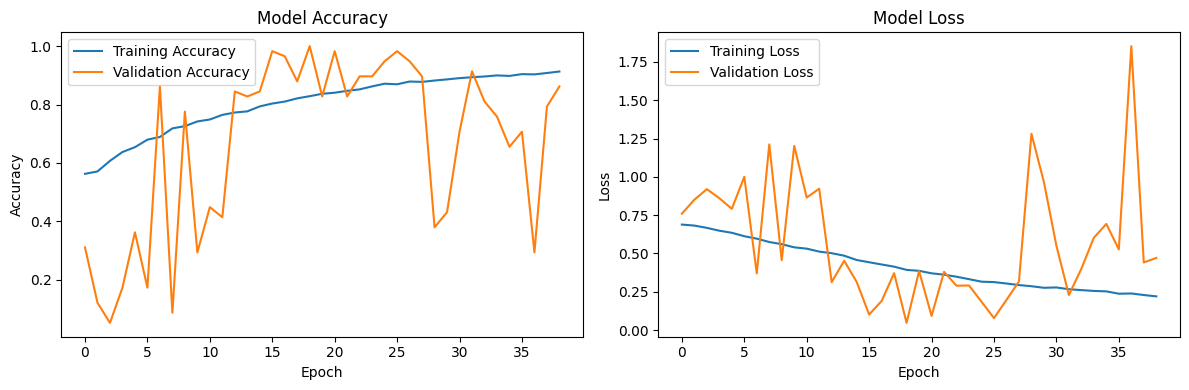

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Cross Validation

### Cross Validation Helper Functions


In [78]:
def get_model(params):
    model = EEG_CNN_LSTM_HPO(
        cnn_kernels_1=params['cnn_kernels_1'],
        cnn_kernel_size_1=params['cnn_kernel_size_1'],
        cnn_kernels_2=params['cnn_kernels_2'],
        cnn_dropout=float(params['cnn_dropout']),
        cnn_dense=params['cnn_dense'],
        lstm_hidden_size=params['lstm_hidden_size'],
        lstm_layers=params['lstm_layers'],
        lstm_dense=params['lstm_dense'],
        dropout=float(params['cnn_dropout']),  # use cnn_dropout as a simple shared dropout param
        num_classes=2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
    elif params['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
    else:
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=1e-4)

    return model, criterion, optimizer

def get_dataset(df, scaler, is_train=False, batch_size=36):
    frequency_count = len(df['Frequency'].unique())
    window_count = len(df['Window'].unique())
    numeric_df = df.drop(['ID', 'Window'], axis=1)

    # shape: (windows, freqs, features)
    full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

    X = full_ndarray[:, :, 2:]     # drop ID/Class columns
    y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

    # Add channel dimension (N, 1, freq, electrodes)
    X = X[..., np.newaxis]          # (N, freq, electrodes, 1)

    # Standardize across the entire dataset
    if is_train:
        scaler.fit(X)

    X = scaler.transform(X)

    return DataLoader(EEGDataset(X, y),
                      batch_size=batch_size,
                      shuffle=is_train)

### Subject-Wise Stratified Leave One Out Cross Validation

Also known as Leave One Subject Out Cross Validation

In [96]:
unique_subjects = df['ID'].unique()
params = {'batch_size': 80, 'cnn_dense': 256, 'cnn_dropout': np.float64(0.38218620920862145),
          'cnn_kernel_size_1': 5, 'cnn_kernel_size_2': 5,
          'cnn_kernels_1': 48, 'cnn_kernels_2': 32,
          'learning_rate': np.float64(0.0017576118123159641), 'lstm_dense': 32,
          'lstm_hidden_size': 128, 'lstm_layers': 3, 'optimizer': 'rmsprop'}
accs = []
batch_size = params['batch_size']

for i, subj in enumerate(unique_subjects):
    print(f"Subject {i} ({subj}):", end=" ")
    scaler = EEGScaler()
    train_loader = get_dataset(df[df['ID'] != subj], scaler, is_train=True, batch_size=batch_size)
    val_loader  = get_dataset(df[df['ID'] == subj], scaler, is_train=False, batch_size=batch_size)
    model, criterion, optimizer = get_model(params)

    # Train with modest epochs; early stopping inside fit handles rest
    history = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=120,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        patience=20,
        is_verbose=False
    )

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    accs.append(acc)
    print("Accuracy:", acc)

print(f"\nLOSOCV Mean Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

Subject 0 (v10p): Early stopping triggered.
Accuracy: 0.5740740740740741
Subject 1 (v12p): Early stopping triggered.
Accuracy: 0.05970149253731343
Subject 2 (v14p): Early stopping triggered.
Accuracy: 0.8208955223880597
Subject 3 (v15p): 

KeyboardInterrupt: 

### Subject-Wise Stratified k-Fold Cross Validation

In [94]:
import random

# map params to integers where needed
params = {'batch_size': 80, 'cnn_dense': 256, 'cnn_dropout': np.float64(0.38218620920862145), 'cnn_kernel_size_1': 5, 'cnn_kernel_size_2': 5, 'cnn_kernels_1': 48, 'cnn_kernels_2': 32, 'learning_rate': np.float64(0.0017576118123159641), 'lstm_dense': 32, 'lstm_hidden_size': 128, 'lstm_layers': 3, 'optimizer': 'rmsprop'}

criterion = nn.CrossEntropyLoss()
unique_subjects = list(df['Window'].unique())
accs = []
variances = []
batch_size = params['batch_size']

K_FOLDS = 5
fold_size = len(unique_subjects) // K_FOLDS

random.shuffle(unique_subjects)

cyclic = itertools.cycle(unique_subjects)
batched_cyclic = batched(cyclic, n=fold_size)
folds = itertools.islice(batched_cyclic, K_FOLDS)

for i, fold in enumerate(folds):
    print(f"Starting fold {i + 1}/{K_FOLDS}")

    train_df = df[~df['Window'].isin(fold)]
    val_df   = df[df['Window'].isin(fold)]

    scaler = EEGScaler()
    train_loader = get_dataset(train_df, scaler, is_train=True, batch_size=batch_size)
    val_loader  = get_dataset(val_df, scaler, is_train=False, batch_size=batch_size)
    model, criterion, optimizer = get_model(params)

    # Train with modest epochs; early stopping inside fit handles rest
    history = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=60,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        patience=15,
        is_verbose=False
    )

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    accs.append(acc)

    last_5_or_less = history["val_losses"]
    last_5_or_less = last_5_or_less[-min(len(last_5_or_less), 5)]
    variance = np.var(last_5_or_less)
    variances.append(variance)

    print(f"Fold {i + 1} Accuracy:", acc)

print(f"k-Fold CV Mean Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

Starting fold 1/5
Fold 1 Accuracy: 0.9250755287009064
Starting fold 2/5
Fold 2 Accuracy: 0.9172205438066465
Starting fold 3/5
Fold 3 Accuracy: 0.9280966767371601
Starting fold 4/5
Fold 4 Accuracy: 0.9196374622356496
Starting fold 5/5
Fold 5 Accuracy: 0.8900302114803625
k-Fold CV Mean Accuracy: 0.9160 ± 0.0135


### Exporting the model

In [ ]:
%pip install --upgrade executorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 3.3 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.0 MB/s  0:00:00
  DEPRECATION: Building 'antlr4-python3-runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'antlr4-python3-runtime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144590 sha256=ed071ee7220fe3ec507b4071f39fdcd75b6d891866168441fa53fa3611fd08c4
  Stored in directory: /root/.cache/pip/wheels/1a/97/

In [ ]:

import os
import executorch
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from pathlib import Path

export_path = Path("exports/eeg_cnn_lstm_hpo.pth")
os.makedirs(export_path.parent, exist_ok=True)
torch.save(model.state_dict(), export_path)

loaded_model = EEG_CNN_LSTM_HPO(
    cnn_kernels_1=params['cnn_kernels_1'],
    cnn_kernel_size_1=params['cnn_kernel_size_1'],
    cnn_kernels_2=params['cnn_kernels_2'],
    cnn_dropout=float(params['cnn_dropout']),
    cnn_dense=params['cnn_dense'],
    lstm_hidden_size=params['lstm_hidden_size'],
    lstm_layers=params['lstm_layers'],
    lstm_dense=params['lstm_dense'],
    dropout=float(params['cnn_dropout']),  # use cnn_dropout as a simple shared dropout param
    num_classes=2
)

loaded_model.load_state_dict(torch.load(export_path, weights_only=True))
loaded_model.eval()

_, width, height, _ = X_train.shape
inputs = (torch.randn(1, 1, width, height), )
exported_program = torch.export.export(loaded_model, inputs)
executorch_program = executorch.exir.to_edge_transform_and_lower(
    exported_program,
    partitioner=[XnnpackPartitioner()]
).to_executorch()

with open("model.pte", "wb") as file:
    file.write(executorch_program.buffer)